# Galaxy Classification with CNN (Pytorch)

Data:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge



References:

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/vision/stable/models.html

3. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

5. https://cs231n.github.io/transfer-learning/



## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-279ef151-ac8f-baf8-0759-b6698cbd4eb7)


## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.manual_seed(0)

## Unzip images

Before running the code, please upload `images_train.zip`, `images_valid.zip` and `images_test.zip` to the workspace.

We upzip these 3 files:

- training images (n=99,808) in folder `images_train`
- validation images (n=24,952) in folder `images_valid`, and
- test images (n=31,191) in folder `images_test`.

In [3]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

#### Unzip from Google Drive

In [4]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')

#### Unzip from Google Colab workspace

In [ ]:
## Unzip training, validation, and test images
unzipping('images_train.zip', 'images_train')
unzipping('images_valid.zip', 'images_valid')
unzipping('images_test.zip', 'images_test')

## Import custom datasets

In [5]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label, int(galaxyid)

## Data Augmentation Transforms

In [6]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
    return train_transform, valid_transform, test_transform

## Parameters

In [7]:
NUM_OF_CLASSES = 8  # there are 8 classes in total
BATCH_SIZE = 64     # batch zize

## Training function

In [8]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
        is_for_inception: True if the model is an inception model
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best train acc
    best_train_acc = 0.0
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            if is_for_inception:
                pred_logits, aux_outputs = model(images)
                loss = criterion(pred_logits, labels) + 0.4*criterion(aux_outputs, labels)
            else:
                pred_logits = model(images)
                loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()
            
        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels, _ in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                pred_logits = model(images)
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())
            # save the best model weights to Google drive
            torch.save(model.state_dict(), os.path.join('drive/MyDrive/gz2_datasets', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:

            # if is best valid acc
            if epoch == (best_epoch - 1):
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s\t<--".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            # not a better model
            else:
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with training accuracy = {:.4f} and validation accuracy = {:.4f}".format(best_epoch, best_train_acc, best_valid_acc))

    # return the best model
    return model, history_dic

## VGG-16(bn) Model

### Create transforms and dataloaders

We set `is_for_inception` to `False`

In [9]:
# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))

Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


### Train

In [11]:
# filename to save
model_name = "gz2_vgg16bn_A"

## Download the pre-trained VGG-16(bn) model
model = models.vgg16_bn(pretrained=True)

# change the last fc layer
model.classifier[6] = nn.Linear(4096, NUM_OF_CLASSES)
print(model.classifier[6]) # print the modified last layer

print("============")
print("Training")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("============")

# move to gpu
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)
# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## train and return the best model
model, history_dic = train_model(model, 200, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False)

## Save the best weights
torch.save(model.state_dict(), model_name + '.pth')
torch.save(model.state_dict(), os.path.join('drive/MyDrive/gz2_datasets', model_name + '.pth'))

## Convert history to dataframe
history_df = pd.DataFrame(history_dic)

## Save the history
history_df.to_csv(model_name + '_history.csv')
history_df.to_csv(os.path.join('drive/MyDrive/gz2_datasets', model_name + '_history.csv'))

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Linear(in_features=4096, out_features=8, bias=True)
Training
Number of trainable parameters: 134301768


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/200	Train loss: 0.7307	Train acc: 0.7338	Valid loss: 0.5775	Valid acc: 0.7908	Time: 30m 56s	<--
Epoch 2/200	Train loss: 0.5712	Train acc: 0.7931	Valid loss: 0.5803	Valid acc: 0.7858	Time: 30m 46s
Epoch 3/200	Train loss: 0.5335	Train acc: 0.8059	Valid loss: 0.5606	Valid acc: 0.7908	Time: 30m 47s
Epoch 4/200	Train loss: 0.5097	Train acc: 0.8138	Valid loss: 0.4910	Valid acc: 0.8178	Time: 30m 49s	<--
Epoch 5/200	Train loss: 0.4953	Train acc: 0.8183	Valid loss: 0.4898	Valid acc: 0.8209	Time: 30m 52s	<--
Epoch 6/200	Train loss: 0.4814	Train acc: 0.8221	Valid loss: 0.4677	Valid acc: 0.8298	Time: 30m 51s	<--
Epoch 7/200	Train loss: 0.4718	Train acc: 0.8259	Valid loss: 0.4705	Valid acc: 0.8264	Time: 30m 49s
Epoch 8/200	Train loss: 0.4630	Train acc: 0.8300	Valid loss: 0.4727	Valid acc: 0.8258	Time: 30m 50s
Epoch 9/200	Train loss: 0.4548	Train acc: 0.8318	Valid loss: 0.4582	Valid acc: 0.8309	Time: 30m 54s	<--
Epoch 10/200	Train loss: 0.4494	Train acc: 0.8331	Valid loss: 0.4763	Valid acc: 

## Plot loss and accuracy history


In [10]:
# filename to save
model_name = "gz2_vgg16bn_A"

## Download the pre-trained VGG-16(bn) model
model = models.vgg16_bn(pretrained=True)

# change the last fc layer
model.classifier[6] = nn.Linear(4096, NUM_OF_CLASSES)
print(model.classifier[6]) # print the modified last layer

# load weights
model.load_state_dict(torch.load(os.path.join('drive/MyDrive/gz2_datasets', model_name + '.pth')))

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Linear(in_features=4096, out_features=8, bias=True)


<All keys matched successfully>

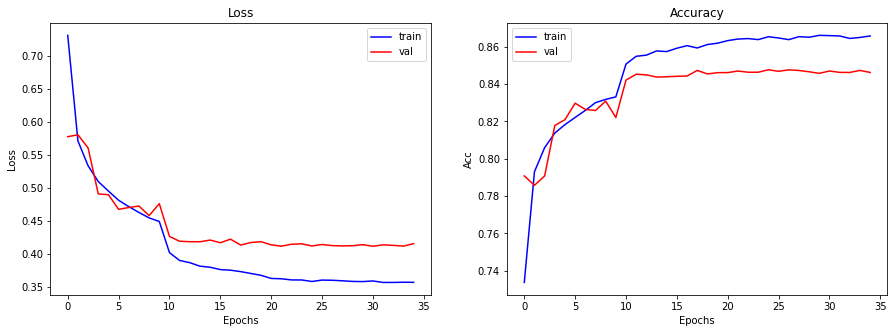

In [11]:
# read csv
history_df = pd.read_csv(os.path.join('drive/MyDrive/gz2_datasets', model_name + '_history.csv'))

# number of epochs
epochs = len(history_df['valid_acc'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_df['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_df['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_df['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_df['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()
plt.show()

## Predict test data

In [14]:
def predict_model(model):
    """
    Predict test data
    """
    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in test_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            pred_logits = model(images)
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    return y_true, y_pred, predict_df

In [15]:
# weights filename
weights_filename = model_name + ".pth"
print("weights_filename = {}".format(weights_filename))

# move to gpu
model = model.to(device)

# model evaluation
y_true, y_pred, predict_df = predict_model(model)

# save predict_df
predict_df.to_csv(model_name + '_predictions.csv')
predict_df.to_csv(os.path.join('drive/MyDrive/gz2_datasets', model_name + '_predictions.csv'))

weights_filename = gz2_vgg16bn_A.pth


In [16]:
predict_df.head()

,GalaxyID,class,pred
0,216255,0,0
1,161897,1,1
2,142357,0,0
3,218373,4,4
4,252047,4,4


## Evaluation metrics

Class 0: accuracy = 0.9313 (Round Elliptical)
Class 1: accuracy = 0.8877 (In-between Elliptical)
Class 2: accuracy = 0.7451 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.9105 (Edge-on Spiral)
Class 4: accuracy = 0.8546 (Barred Spiral)
Class 5: accuracy = 0.7877 (Unbarred Spiral)
Class 6: accuracy = 0.5077 (Irregular)
Class 7: accuracy = 0.7052 (Merger)
Total Accuracy = 0.8522

Recall = 0.7912

F1 score = 0.7979



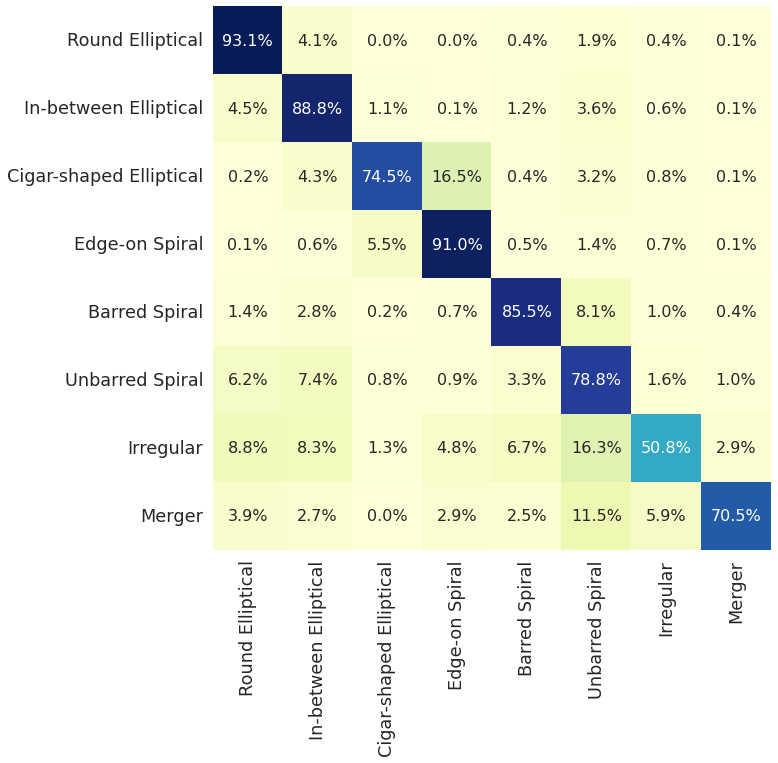

In [17]:
# galaxy classes
gxy_labels = ['Round Elliptical',
              'In-between Elliptical',
              'Cigar-shaped Elliptical',
              'Edge-on Spiral',
              'Barred Spiral',
              'Unbarred Spiral',
              'Irregular',
              'Merger']

# confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

# accuracy of each class
for c in range(8):
    print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), gxy_labels[c]))
print("================")

# accuracy
acc = accuracy_score(y_true, y_pred)
print("Total Accuracy = {:.4f}\n".format(acc))

# recall
recall = recall_score(y_true, y_pred, average='macro')
print("Recall = {:.4f}\n".format(recall))

# f1 score
F1 = f1_score(y_true, y_pred, average='macro')
print("F1 score = {:.4f}\n".format(F1))

# plot confusion matrix
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
plt.show()